In [52]:
using PyPlot
using JuMP, Ipopt

In [53]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

## Model setup

#### Physical parameters

In [54]:
# Model domain
dt = 1.
t = Array(2020:dt:2200);

ECS = 3.0; # "Best-guess" equilibrium climate sensitivity (ECS)

H = 2400.; # depth of surface ocean mixed layer [m]
ρ = 1000.; # density of liquid water [kg m^-3]
Cp = 4180.0; # specific heat capacity of liquid  water [J kg^-1 K^-1]

Cd = Cp * ρ * H # upper ocean heat capacity
τd = 200. # deep ocean relaxation time scale [years] (similar to Gregory 2000, Held 2009)
γ = Cd / τd

physics = Physics(ECS, 415., 1.1, Cd, γ);

#### Economic parameters

Assume damages of 2% of global world product (GWP) for 3$^{\circ}$C of warming (similar to DICE damage function).

In [55]:
GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.0 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

In [56]:
# inspired by RCP8.5 https://en.wikipedia.org/wiki/Representative_Concentration_Pathway#/media/File:All_forcing_agents_CO2_equivalent_concentration.png
baseline_emissions_scenario = baseline_emissions(t, 10., 2080., 40.)

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0., # Assumed initial condition of no deployments in 2020
    baseline_emissions_scenario
);

### Initialize model

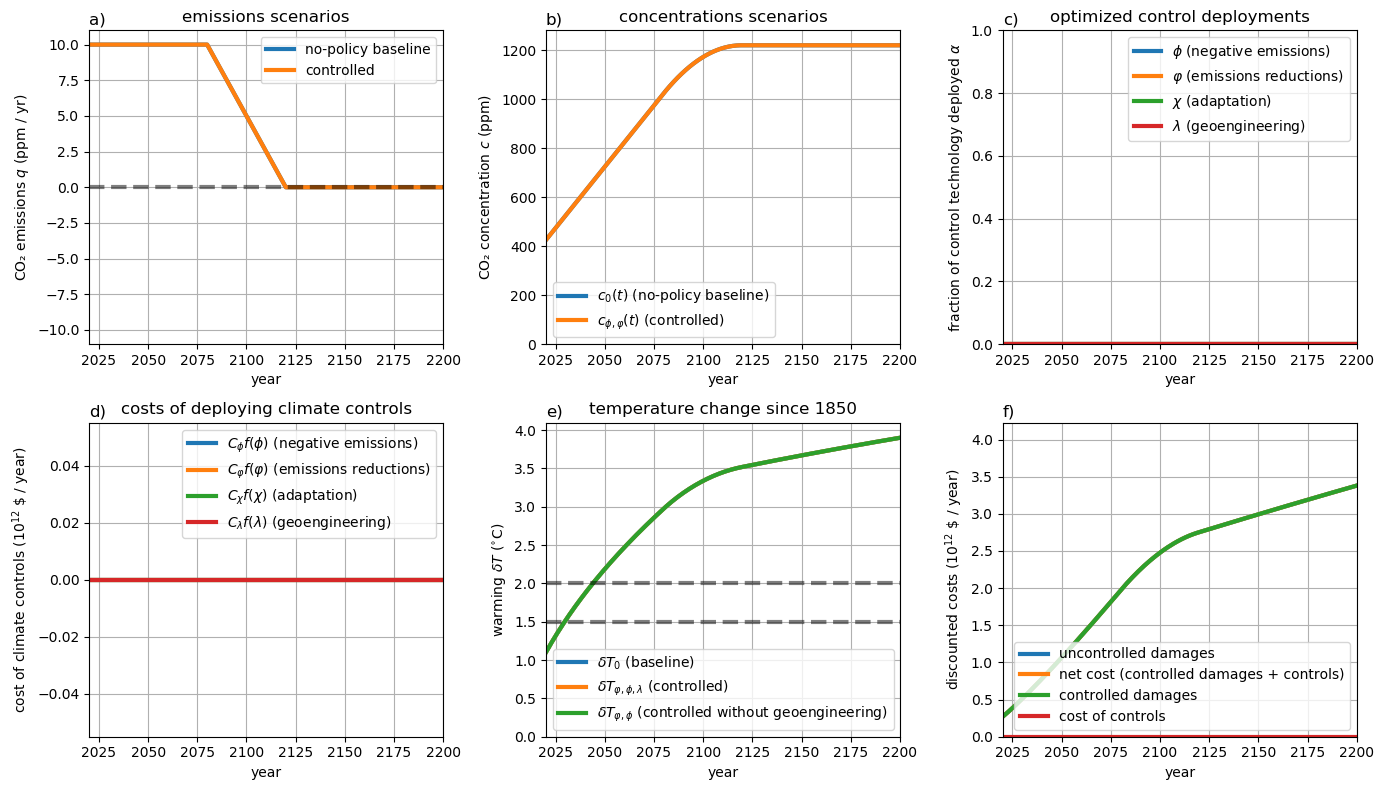

Social cost of carbon: $49.11.

In [57]:
ensemble = Dict{String, ClimateModel}();

name = "Example configuration";
present_year = 2020.

# Arbitrary initial guess of climate control policies,
# to be optimized later!
controls = init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
model = ClimateModel(name, t, dt, present_year, economics, physics, controls);

# Plot initial state (baseline scenario; zero controls)
plot_state(model)

print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

## Model optimization

In [58]:
optimize_controls!(model);

Found optimal solution for model name: Example configuration

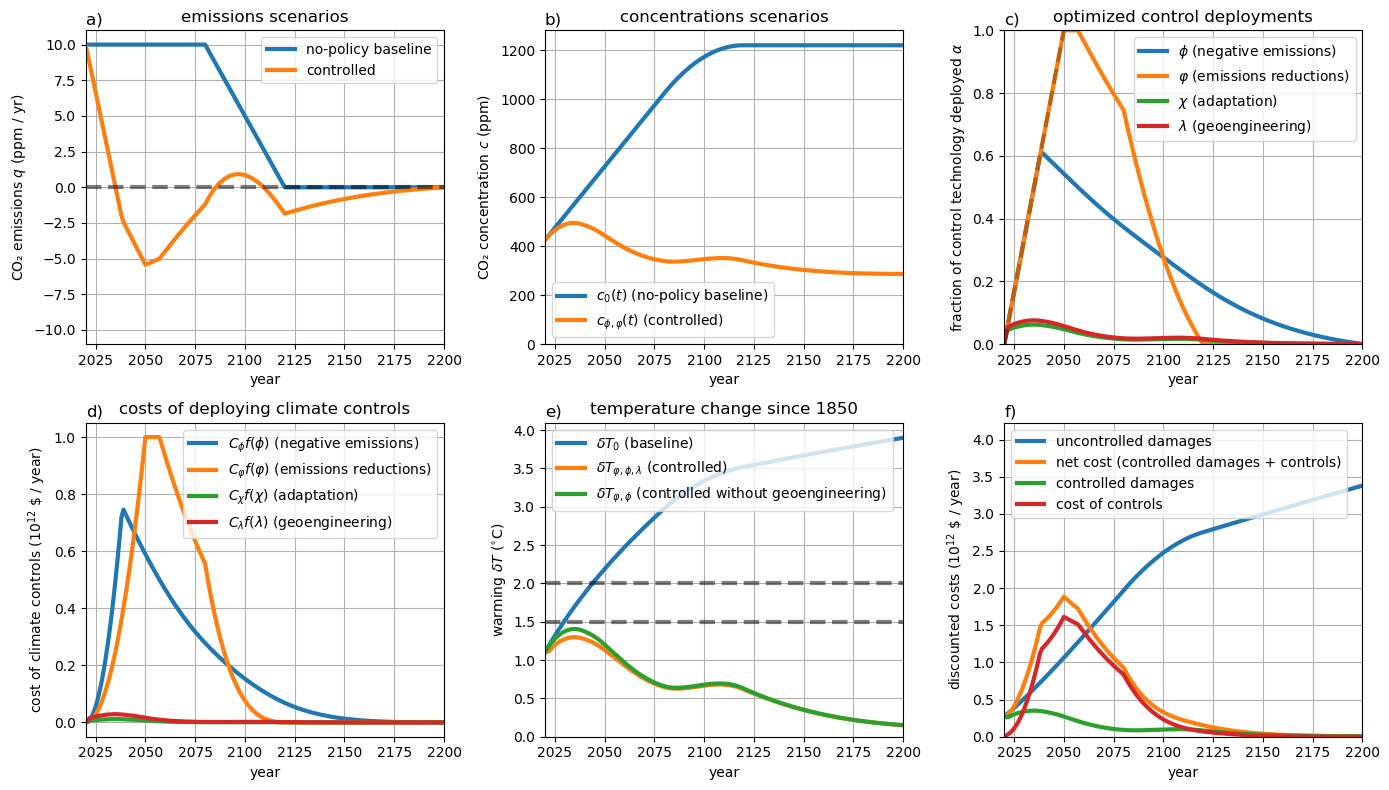

In [59]:
# plot optimized model state
maxslope = 1. /30.
plot_state(model)
subplot(2,3,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25)
savefig("../figures/model_state_two-box-heat-model.png", dpi=100, bbox_inches="tight")

In [60]:
print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

Social cost of carbon: $23.19.